[View in Colaboratory](https://colab.research.google.com/github/HammadB/ProceduralLayout/blob/master/Layout.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import copy

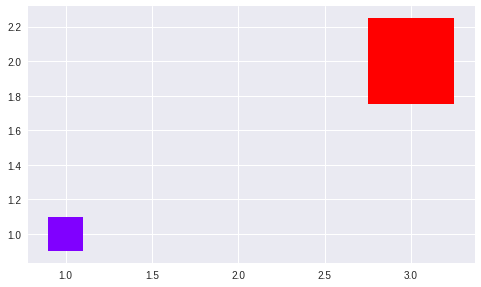

In [7]:
#Boilerplate code for 
class Vector2(object):
  x = None
  y = None
  
  def __init__(self, x, y):
    self.x = x
    self.y = y 
  
class LayoutObject(object):
  empty = 0
  
  def getIntersection(self, otherLayoutObject):
    return None #not implemented
 
  def __copy__(self):
    print("ERROR NOT IMPLEMENTED")
  
class Box(LayoutObject):
  center = None
  size = None
  uL = None
  uR = None
  bL = None
  bR = None

  #Center is a Vector2
  def __init__(self, center, size):
    self.center = center
    self.size = size
    self.uL = Vector2(center.x - size/2, center.y + size/2)
    self.uR = Vector2(center.x + size/2, center.y + size/2) 
    self.bL = Vector2(center.x - size/2, center.y - size/2)    
    self.bR = Vector2(center.x + size/2, center.y - size/2) 
  
  def __copy__(self):
    return Box(self.center, self.size)
  
  #Only supports intersections with other boxes
  def getIntersection(self, otherLayoutObject):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(self.uL.x, otherLayoutObject.uL.x)
    yA = min(self.uL.y, otherLayoutObject.uL.y) #A : upper left
    xB = min(self.bR.x, otherLayoutObject.bR.x)
    yB = max(self.bR.y, otherLayoutObject.bR.y) #B: bottom right
    return max(0, xB - xA) * max(0, yA - yB)

class Layout(object):
  
  def __init__(self, *args):
    self._myLayoutObjects = list(args)
  
  def getLayoutObjects(self):
    return self._myLayoutObjects
  
  def drawLayout(self):
    plt.axes()
    x = np.arange(len(self._myLayoutObjects))
    ys = [i+x+(i*x)**2 for i in range(len(self._myLayoutObjects))]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    #For now all layout objects are Boxes
    i = 0
    for box in self._myLayoutObjects:
      shape = plt.Rectangle((box.bL.x, box.bL.y), box.size, box.size, fc=colors[i])
      plt.gca().add_patch(shape)
      i += 1
    plt.axis('scaled')
    plt.show()
   
  def __copy__(self):
    newLayoutObjects = []
    for layoutObject in self.getLayoutObjects():
      newLayoutObject = copy(layoutObject)
      newLayoutObjects.append(newLayoutObject)
    return Layout(*newLayoutObjects) 

b = Box(Vector2(1, 1), 0.2)
b2 = Box(Vector2(3, 2),  0.5)
layout = Layout(b, b2)
layout.drawLayout()


In [0]:
#Constraints

class Constraint(object):
  
  def evaluate_cost():
    return 0

class AreaConstraint(Constraint):
  
  #Returns area of all layoutObjects
  def __init__(self, layoutObjects):
    self._myConstrainedObjects = layoutObjects
  
  def getArea(self):
    sumOfAreas = 0
    for i in range(len(self._myConstrainedObjects)):
      for j in range(i + 1, len(self._myConstrainedObjects)):
        sumOfAreas += self._myConstrainedObjects[i].getIntersection(self._myConstrainedObjects[j])
    return sumOfAreas
    

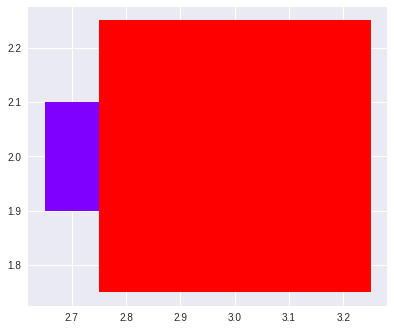

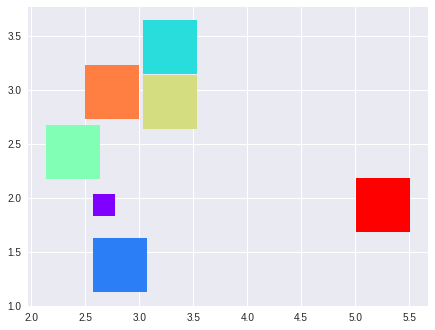

In [12]:
def boltzmann(cost, beta=1.0):
  return np.exp(-beta*cost)

def acceptanceProbability(current_cost, proposed_cost):
  return min(1, boltzmann(proposed_cost)/boltzmann(current_cost))


def get_cost(layout):
  areaConstraintObj = AreaConstraint(layout.getLayoutObjects())
  return areaConstraintObj.getArea()


def propose_new_layout(current_layout):
  new_layout_objects = []
  for rect in current_layout.getLayoutObjects():
    rect_center = rect.center 
    new_center = Vector2(rect_center.x + np.random.normal(scale=0.01), rect_center.y + np.random.normal(scale=0.01))
    new_rect = Box(new_center, rect.size)
    new_layout_objects.append(new_rect)
  
  return Layout(*new_layout_objects)


def metropolis_hastings(initial_layout, num_iters=10000):
  cur_cost = get_cost(initial_layout)
  cur_layout = initial_layout
  
  for i in range(num_iters):
    new_layout = propose_new_layout(cur_layout)
    new_cost = get_cost(new_layout)
    
    if np.random.random() < acceptanceProbability(cur_cost, new_cost):
      cur_layout = new_layout
      cur_cost = new_cost
      if cur_cost == 0:
#         print("@@@@@@@@@!!!!@@@@")
        break
      
    #cur_layout.drawLayout()

  return cur_layout


b = Box(Vector2(2.75, 2), 0.2)
b2 = Box(Vector2(3, 2),  0.5)
b3 = Box(Vector2(3, 2),  0.5)
b4 = Box(Vector2(3, 2),  0.5)
b5 = Box(Vector2(3, 2),  0.5)
b6 = Box(Vector2(3, 2),  0.5)
b7 = Box(Vector2(3, 2),  0.5)
layout = Layout(b, b2, b3 ,b4, b5, b6, b7)
layout.drawLayout()
final_layout = metropolis_hastings(layout, num_iters=10000)
final_layout.drawLayout()